### Programming section

In [ ]:
## Install Required libraries
! pip install librosa
! pip install numpy
! pip install pandas
! pip install soundfile

In [1]:
#### Importing Libraries
import librosa
import numpy as np
import os
import math
import pandas as pd

import soundfile as sf

### Question Three Music Transcription

#### 3.1 Projection

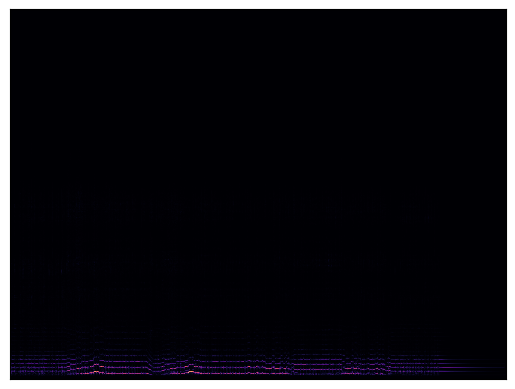

In [2]:
audio, sr = librosa.load('./hw2materials/Misirlou.wav', sr = 16000)
spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
M = abs(spectrogram)
phase = spectrogram/(M + 2.2204e-16) # to prevent zero division errors
librosa.display.specshow(M)

In [3]:
notes_spectrograms = []

for note_file in os.listdir('./hw2materials/notes_scale/'):
    audio, sr = librosa.load('./hw2materials/notes_scale/'+note_file, sr = 16000)
    note_spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
    note_spectrogram = abs(note_spectrogram)
    middle = note_spectrogram[:, int(math.ceil(note_spectrogram.shape[1]/2))]
    middle[middle < (max(middle)/100)] = 0
    middle = middle/np.linalg.norm(middle)
    notes_spectrograms.append(middle)

#### Compute the joint contribution of all notes to the entire music.

In [4]:
N = np.column_stack(notes_spectrograms)

W = np.matmul(np.linalg.pinv(N), M)

pd.DataFrame(W).to_csv('weights.csv', header=False, index=False)

#### Recompose the music by “playing” each note according to the transcription you found in last question.

In [5]:
#Set all negative items in W to 0
W_format = np.where(W<0, 0, W)

In [6]:
m_hat = np.matmul(N, W_format)

In [7]:
m_difference = np.subtract(M, m_hat)
squared_error = np.sum(m_difference ** 2)

print(f"Value of ||M-m_hat||^2_F = {squared_error}")

Value of ||M-m_hat||^2_F = 4279084.0


In [8]:
signal_hat = librosa.istft(m_hat *phase, hop_length=256, center=False, win_length=2048)
sf.write(f"resynthensized_proj{'spiwan'}.wav", signal_hat, 16000)

### Question Four Style transfer using a Linear Transformation

Reading Audio Files and computing spectrogram

In [9]:
audio, sr = librosa.load('./hw2materials/audio/Synth.wav', sr = 16000)
Synth_spec = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=1024)
M_A = abs(Synth_spec)

In [10]:
audio, sr = librosa.load('./hw2materials/audio/Piano.wav', sr = 16000)
piano_spec = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=1024)
M_B = abs(piano_spec)

In [11]:
audio, sr = librosa.load('./hw2materials/audio/BlindingLights.wav', sr = 16000)
blinding_spec = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=1024)
M_C = abs(blinding_spec)
phase_c = blinding_spec/(M_C + 2.2204e-16) 

#### Determine Matrix of Transformation

In [12]:
# TM_A ≈ M_B therefore T = M_B . inv(M_A)
T = np.matmul(M_B, np.linalg.pinv(M_A))

# Transform M_A
T_MA = np.matmul(T, M_A)
transformation_diff = T_MA - M_B

In [13]:
error = np.sum(transformation_diff**2)

print(f"Error value ||TM_A - M_B||^2_f = {error}")
pd.DataFrame(T).to_csv(f"problem4t{'spiwan'}.csv", header=False, index=False)

Error value ||TM_A - M_B||^2_f = 0.0010671786731109023


#### Style transfer using linear transformation

In [14]:
M_D = np.matmul(T, M_C)
pd.DataFrame(M_D).to_csv(f"problem4{'spiwan'}.csv", header=False, index=False)
signal_hat = librosa.istft(M_D *phase_c, hop_length=256, center=False, win_length=1024)
sf.write(f"problem4{'spiwan'}.wav", signal_hat, 16000)